# Question 7

In [1]:
import json
import datetime,time
import pytz
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statistics import mean
import time

In [2]:
path = "../../projects/project_5/ECE219_tweet_data/"

files = ["tweets_#gohawks.txt", "tweets_#gopatriots.txt", \
        "tweets_#nfl.txt", "tweets_#patriots.txt", \
        "tweets_#sb49.txt", "tweets_#superbowl.txt"]
topics = ["gohawks", "gopatriots", "nfl", "patriots", "sb49", "superbowl"]

for i, fl in enumerate(files):
    print("files[" + str(i) + "] => " + fl)

files[0] => tweets_#gohawks.txt
files[1] => tweets_#gopatriots.txt
files[2] => tweets_#nfl.txt
files[3] => tweets_#patriots.txt
files[4] => tweets_#sb49.txt
files[5] => tweets_#superbowl.txt


#### Prepare for data

In [3]:
def transfer_time(data_raw,time_type):
    
    pst_tz = pytz.timezone('America/Los_Angeles')
    
    # sort according to time
    pddata_raw = pd.DataFrame(data_raw,columns=['time','tweets','retweets','followers','mentioned',\
                                                'media','active','author','favourites_count','title'])
    pddata_raw = pddata_raw.sort_values(by = 'time')
    pddata_raw = pddata_raw.reset_index(drop=True)               

    # calculate hour index and minute index from time
    if time_type == 'hour':
        hour_accu = []
        for index, row in pddata_raw.iterrows():  
            p = datetime.datetime.fromtimestamp(row['time'], pst_tz)  
            hour_accu.append(((p.month-1)*31+p.day-14)*24+p.hour)                             
        pddata_raw['time'] = hour_accu
    elif time_type == 'minute':
        minu_accu = []
        for index, row in pddata_raw.iterrows():  
            p = datetime.datetime.fromtimestamp(row['time'], pst_tz)                    
            minu_accu.append((((p.month-1)*31+p.day-14)*24 + (p.hour-0))*12 + p.minute//5)             
        pddata_raw['time'] = minu_accu    
    else:
        print("Invalid time type")
        
    return pddata_raw

In [4]:
def generate_df(pddata_raw):
    """
    Create a new dataframe with desired form
    """
    df = pd.DataFrame([],columns=['time unit','tweets','retweets','followers sum','followers max',\
                                  'mentioned','media','active','author','favourites_count','title'])
    
    col = pddata_raw.columns.get_loc('time')
    df['time unit'] = range(int(pddata_raw.iloc[len(pddata_raw.index)-1,col] - pddata_raw.iloc[0,col]+1))

    df['tweets'] = pddata_raw.groupby("time")['tweets'].sum()
    df['retweets'] = pddata_raw.groupby("time")['retweets'].sum()
    df['followers sum'] = pddata_raw.groupby("time")['followers'].sum()
    df['followers max'] = pddata_raw.groupby("time")["followers"].max()
    df['mentioned'] = pddata_raw.groupby("time")['mentioned'].sum()
    df['media'] = pddata_raw.groupby("time")['media'].sum()
    df['active'] = pddata_raw.groupby("time")['active'].mean()  
    df['author'] = pddata_raw.groupby("time")['author'].nunique() # count number of not-repeating authors    
    df['favourites_count'] = pddata_raw.groupby("time")['favourites_count'].sum()
    df['title'] = pddata_raw.groupby("time")['title'].mean()
            
    # reset index of df
    df = df.fillna(0).reset_index(drop=True)
    
    return df

In [5]:
def prase_dataset(files):
    """
    Prase x conponent of the dataset into pandas DataFrame including columns of:
    tweets, retweets, total_followers, max_followers, mentioned, media, active, author, favourites_count, title
    with lines of hours,
    where mentioned: number of @ in tweets per hour
          media: number of url in tweets per hour
          active: a measure of active state of author
          author: number of unique authors post tweet per hour
          favourites_count: the total number of likes by this user
          title: length of this tweet's title
    Prase y of dataset as number of tweets in the next hour.
    """
    start_time = time.mktime(time.strptime("2015-02-01 08:00:00",'%Y-%m-%d %H:%M:%S'))
    end_time = time.mktime(time.strptime("2015-02-01 20:00:00",'%Y-%m-%d %H:%M:%S'))   

    start_hour_idx = ((2-1)*31+1-14)*24+8
    end_hour_idx = ((2-1)*31+1-14)*24+20
    start_minute_idx = (((2-1)*31+1-14)*24 + (8-0))*12 + 0//5    
        
    # extract raw features
    data_raw = [[],[],[]]
    for file in files:
        for line in open(path + file, 'r') :
            row_tmp = []
            a = json.loads(line)
            citation_date = a['citation_date']
            tweet = 1
            retweet = a['metrics']['citations']['total']
            foll = a['author']['followers']             
            ment = len(a['tweet']['entities']['user_mentions'])        
            medi = len(a['tweet']['extended_entities']['media']) if 'extended_entities' in a['tweet'] else 0
            hist_tw = a['tweet']['user']["statuses_count"]
            hist_yr = a['tweet']['user']['created_at'][-4:]
            acti = hist_tw/(2015-float(hist_yr)+1) 
            auth = a['author']['name']
            favo = a['tweet']['user']['favourites_count']
            titl = len(a['title'])

            # append to row_tmp
            row_tmp.append(citation_date)        
            row_tmp.append(tweet)        
            row_tmp.append(retweet)
            row_tmp.append(foll)    
            row_tmp.append(ment) 
            row_tmp.append(medi) 
            row_tmp.append(acti)  
            row_tmp.append(auth)
            row_tmp.append(favo)
            row_tmp.append(titl)

            # assign to 3 periods
            if citation_date < start_time:
                data_raw[0].append(row_tmp)
            elif citation_date < end_time:
                data_raw[1].append(row_tmp)
            else:
                data_raw[2].append(row_tmp)            

    # generate raw pandas dataframe
    pddata_raw_1 = transfer_time(data_raw[0],'hour')
    pddata_raw_2 = transfer_time(data_raw[1],'minute')
    pddata_raw_2['time'] = pddata_raw_2['time'] - start_minute_idx
    pddata_raw_3 = transfer_time(data_raw[2],'hour')
    pddata_raw_3['time'] = pddata_raw_3['time'] - end_hour_idx - 1    
            
    # generate df and df_y for each time slot
    df_1 = generate_df(pddata_raw_1)  
    df_y_1 = df_1.iloc[1:,1].reset_index(drop=True)
    df_1 = df_1[:len(df_y_1)]
    
    df_2 = generate_df(pddata_raw_2)
    df_y_2 = df_2.iloc[1:,1].reset_index(drop=True)
    df_2 = df_2[:len(df_y_2)]
   
    df_3 = generate_df(pddata_raw_3)
    df_y_3 = df_3.iloc[1:,1].reset_index(drop=True)
    df_3 = df_3[:len(df_y_3)]
    
    return (df_1.iloc[:,1:],df_y_1), (df_2.iloc[:,1:],df_y_2), (df_3.iloc[:,1:],df_y_3)

#### Train linear regression model

In [6]:
def train_lr(files):
    """
    This function gets data and train using a linear regression model
    """    
    (df_1,df_y_1),(df_2,df_y_2),(df_3,df_y_3) = prase_dataset(files)
    print('Parse data finished','\n')

    reg_1 = LinearRegression().fit(df_1, df_y_1)
    pred_y_1 = reg_1.predict(df_1)
    MSE_1 = mean_squared_error(df_y_1, pred_y_1)
    R2_1 = r2_score(df_y_1, pred_y_1)    
    print(topics[i], ' of time period 1')
    print('MSE for test data = ',MSE_1)
    print('R2 score for test data = ',R2_1,'\n')   

    reg_2 = LinearRegression().fit(df_2, df_y_2)
    pred_y_2 = reg_2.predict(df_2)
    MSE_2 = mean_squared_error(df_y_2, pred_y_2)
    R2_2 = r2_score(df_y_2, pred_y_2)    
    print(topics[i], ' of time period 2')
    print('MSE for test data = ',MSE_2)
    print('R2 score for test data = ',R2_2,'\n') 

    reg_3 = LinearRegression().fit(df_3, df_y_3)
    pred_y_3 = reg_3.predict(df_3)
    MSE_3 = mean_squared_error(df_y_3, pred_y_3)
    R2_3 = r2_score(df_y_3, pred_y_3)    
    print(topics[i], ' of time period 3')
    print('MSE for test data = ',MSE_3)
    print('R2 score for test data = ',R2_3,'\n') 
    
    return (df_1, df_y_1, pred_y_1), (df_2, df_y_2, pred_y_2), (df_3, df_y_3, pred_y_3)

## Results

In [8]:
(df_1, df_y_1, pred_y_1), (df_2, df_y_2, pred_y_2), (df_3, df_y_3, pred_y_3) = train_lr(files)

Parse data finished 

superbowl  of time period 1
MSE for test data =  3875744.889767636
R2 score for test data =  0.48313710207691474 

superbowl  of time period 2
MSE for test data =  13255242.358842317
R2 score for test data =  0.8836219181473968 

superbowl  of time period 3
MSE for test data =  241287.50729199345
R2 score for test data =  0.9213747152685308 



In [9]:
def plot_recipe(df_y, pred_y):
    """
    This function plots fitted values vs true values
    """
    plt.figure()
    area = np.pi * (4)**2/4
    plt.scatter(df_y, pred_y, s = area)
    plt.plot([df_y.min(), df_y.max()], [df_y.min(), df_y.max()], 'k--', lw = 1)
    plt.xlabel('true values')
    plt.ylabel('fitted values')
    plt.show()

In [10]:
import statsmodels.api as sm
def ols_regression(df, df_y):
    X2 = sm.add_constant(df)
    y = df_y.as_matrix()
    lm = sm.OLS(y, X2).fit()
    print(lm.summary())
    print(list(df))

/home/fs/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


#### period 1

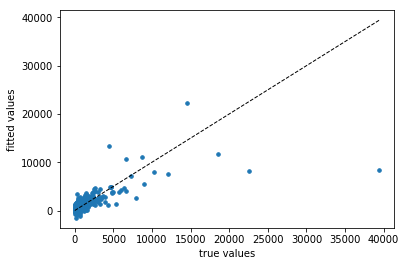

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     40.01
Date:                Wed, 20 Mar 2019   Prob (F-statistic):           2.34e-55
Time:                        23:43:17   Log-Likelihood:                -3952.8
No. Observations:                 439   AIC:                             7928.
Df Residuals:                     428   BIC:                             7972.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.055e+04   1935.300  

In [11]:
plot_recipe(df_y_1,pred_y_1)
ols_regression(df_1, df_y_1)

#### period 2

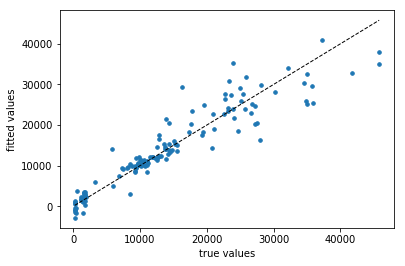

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     100.2
Date:                Wed, 20 Mar 2019   Prob (F-statistic):           1.25e-56
Time:                        23:43:44   Log-Likelihood:                -1375.5
No. Observations:                 143   AIC:                             2773.
Df Residuals:                     132   BIC:                             2806.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             2.902e+04   7407.538  

In [12]:
plot_recipe(df_y_2,pred_y_2)
ols_regression(df_2, df_y_2)

#### period 3

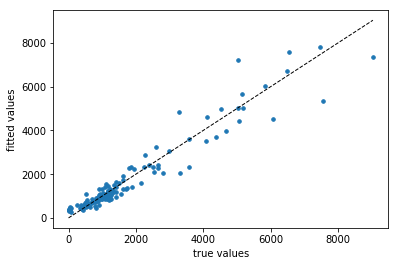

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     144.1
Date:                Wed, 20 Mar 2019   Prob (F-statistic):           6.05e-63
Time:                        23:44:06   Log-Likelihood:                -1020.5
No. Observations:                 134   AIC:                             2063.
Df Residuals:                     123   BIC:                             2095.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -417.1751   1753.400  

In [13]:
plot_recipe(df_y_3,pred_y_3)
ols_regression(df_3, df_y_3)